In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def execute_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    logger = make_logger(output_dir, file_level=logging.DEBUG)

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path, device=conf.get("device"))
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    policy_class = class_from_package("policy", conf.get("policy_class"))
    policy = policy_class(**conf.get("policy_conf", {}))

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization
    generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)

    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    # cProfile.run("generator.generate(root=root, **generation_conf)"")
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()
    
    return generator, conf

def queue_yaml(*args: str):
    for yaml_path in args:
        execute_yaml(yaml_path)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
c:\Users\fsfsf\anaconda3\envs\v3-forge\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\fsfsf\anaconda3\envs\v3-forge\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Is CUDA available: True
Starting generation...
1- time: 0.00, reward: -0.14264061074081438, node: PEPTIDE1{[ac].Q.L.D.A.F}$$$$
2- time: 0.00, reward: 0.017595183895400938, node: PEPTIDE1{[ac].[dF].R.W.[am]}$$$$
3- time: 0.00, reward: -0.336493490307569, node: PEPTIDE1{R.[dP].[dK].P.[dQ].Q.F.F.G.L.M.[am]}$$$$
4- time: 0.20, reward: -0.7166643212491591, node: PEPTIDE1{[ac].F.Q.S.K.N.N.V.F.C.D.G.Y.F.E.R.L.C.A.K.L.[am]}$$$$
5- time: 0.20, reward: -0.3246712566727025, node: PEPTIDE1{[ac].P.S.P.W.A.T.C.D.F.[am]}$$$$
6- time: 0.61, reward: -0.43133201050358044, node: PEPTIDE1{R.K.R.W.W.W.F.G.R.T.G.K.F.G.K.F.V.S.R.F.V.F.[am]}$$$$
7- time: 0.61, reward: -0.4231033133202262, node: PEPTIDE1{R.G.D.R}$$$$
8- time: 0.80, reward: -0.22645152397929763, node: PEPTIDE1{Y.W.Q.W.I.W.R.P.S.R.S}$$$$
9- time: 0.80, reward: -0.18885832295454585, node: PEPTIDE1{Y.R.T.F.[am]}$$$$
10- time: 0.80, reward: -0.4436924406832734, node: PEPTIDE1{Y.G.G.F.L.R.R.I.R.[dP].K.K.[am]}$$$$
11- time: 0.94, reward: -0.792117100

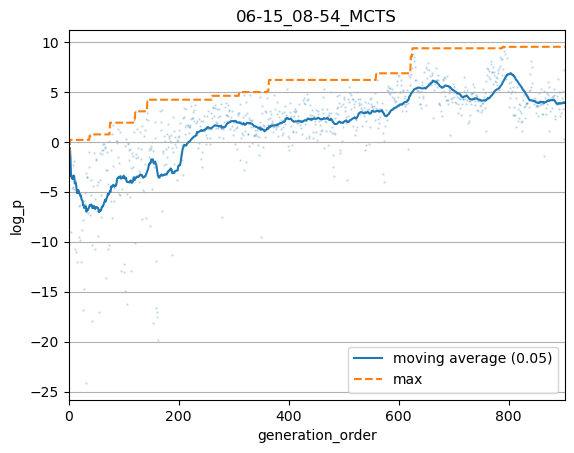

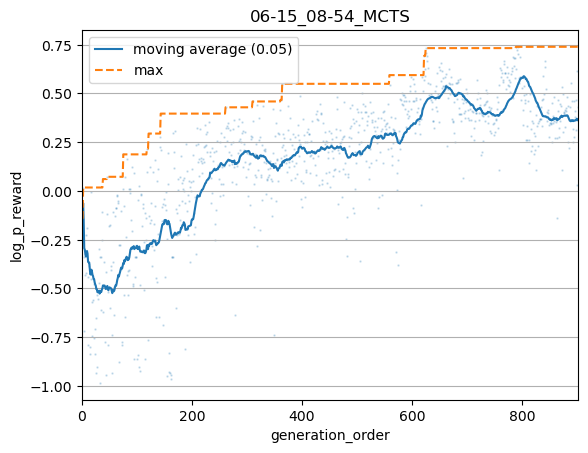

number of generated nodes: 902
valid rate: 0.636046511627907
unique rate: 0.8883720930232558
node_per_sec: 15.02703717210491


In [3]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
generator, conf = execute_yaml(c2)
# queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [14]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook